<a href="https://colab.research.google.com/github/nekotanku/colab/blob/master/cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img, ImageDataGenerator
import os
import shutil
from PIL import Image


from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Input, Dropout



Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:

if os.path.exists('/content/images/')==False:
    id = '1aRBNE4E3z0VHCg_YSLkaYUQKr60sR6fv'  # 共有リンクで取得した id= より後の部分

    downloaded = drive.CreateFile({'id': id})

    downloaded.GetContentFile('images.zip')
    
    
else:
    pass


In [0]:
if os.path.exists('/content/images/')==False:
    !unzip images.zip
else:
    pass

In [0]:
kind_list = ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian'
            ,'Ragdoll','Russian_Blue','Siamese','Sphynx',
        'american_bulldog','american_pit_bull_terrier','basset_hound','beagle','boxer',
        'chihuahua', 'english_cocker_spaniel','english_setter', 'german_shorthaired','great_pyrenees',
        'havanese','japanese_chin','keeshond','leonberger','miniature_pinscher','newfoundland','pomeranian',
        'pug', 'saint_bernard','samoyed','scottish_terrier','shiba_inu','staffordshire_bull_terrier',
        'wheaten_terrier','yorkshire_terrier']


In [8]:
!ls

adc.json  images  images.zip  __MACOSX	sample_data


In [0]:
#種別にディレクトリ作成
for j in kind_list:
    if  os.path.exists('/content/images/'+str(j)+'/') ==True:
        pass
    else :
        os.mkdir('/content/images/'+str(j)+'/')


In [0]:
#種別に写真を分けて格納

for j in kind_list:
    for i in range (1,500):
        if os.path.exists('/content/images/'+str(j)+'_'+str(i)+'.jpg') ==False:
            pass
        else:
            shutil.move('/content/images/'+str(j)+'_'+str(i)+'.jpg', '/content/images/'+str(j)+'/')

In [0]:
#謎のmat形式の画像？を削除
for i in range(100,103):
    if  os.path.exists('/content/images/Abyssinian_'+str(i)+'.mat') ==False:
        pass
    else:
        os.remove('/content/images/Abyssinian_'+str(i)+'.mat')

In [0]:
data_img=[]
kind_label=[]
img_size = 224
for j in  kind_list:
    for i in range(1,300):
        if os.path.exists('/content/images/'+str(j)+'/'+str(j)+'_'+str(i)+'.jpg') ==False:
            pass    
        
        else:
            file_list = glob.glob('/content/images/'+str(j)+'/'+str(j)+'_'+str(i)+'.jpg')
            for file in file_list:
                img_path = file
                
                img = load_img(img_path, target_size=(img_size, img_size))
           
                x = img_to_array(img)
                
                #x = np.expand_dims(x, axis=0)
            
                #x = preprocess_input(x)
                
                data_img.append(x)
                
                kind_label.append(j) 


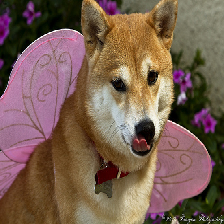

In [0]:
Image.fromarray(np.uint8(data_img[6500]))

In [0]:
kind_label[6500]

'shiba_inu'

In [0]:
print(np.array(data_img).shape)

(7390, 224, 224, 3)


In [0]:
print(np.array(kind_label).shape)

(7390,)


plt.figure()
plt.imshow(data_img[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [0]:
Y_dummy = pd.get_dummies(kind_label)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    data_img, Y_dummy, test_size=0.1, random_state=22, stratify=Y_dummy)

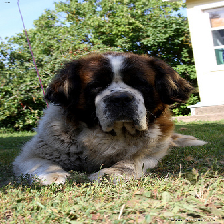

In [0]:
Image.fromarray(np.uint8(X_test[2]))

In [0]:
print(np.array(X_train).shape)

(6651, 224, 224, 3)


In [0]:
print(np.array(y_train).shape)

(6651, 37)


In [0]:
X_train=np.array(X_train, dtype='f4')
y_train = np.array(y_train, dtype='f4')
X_test = np.array(X_test, dtype='f4')
y_test = np.array(y_test, dtype='f4')

In [0]:
base_model = InceptionV3(include_top = False, weights='imagenet', input_tensor=None, input_shape=(224,224,3))


87916544/87910968 [==============================] - 1s 0us/step


In [0]:
base_model.summary()

In [0]:
from keras.models import Model
# 中間層を出力するモデル
#intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.layers[310].output)

# Denseレイヤーを接続
#x =intermediate_layer_model.output
x = base_model.output
x=GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x=Dropout(0.5)(x)
predictions = Dense(len(kind_list), activation='softmax')(x)


#data拡張

datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 0,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False)

# 転移学習モデル
transfer_model = Model(inputs=base_model.input, outputs=predictions)

#for layer in base_model.layers[:249]:
 #   layer.trainable = False
    
   # if layer.name.startswith('batch_normalization'):
     #   layer.trainable = True

#for layer in base_model.layers[249:]:
  #  layer.trainable = True

    


# 一旦全レイヤーをフリーズ
#for layer in transfer_model.layers:
   # layer.trainable = False

#for i, layer in enumerate(transfer_model.layers):
    #print(i, layer.name)

#transfer_model.layers[310].trainable = True
#transfer_model.layers[311].trainable = True

# 最終段のDenseだけ再学習する
for layer in transfer_model.layers[:310]:
    layer.trainable = False
for layer in transfer_model.layers[310:]:
    layer.trainable = True

transfer_model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

#from keras.optimizers import SGD
#transfer_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])


#転移学習
#transfer_model.fit(X_train, y_train, epochs=10, batch_size=32,
                   #validation_data=(X_test, y_test))

hist=transfer_model.fit_generator(
                             datagen.flow(X_train, y_train, batch_size=32), 
                             epochs=10, 
                             validation_data=(X_test, y_test))

#精度確認用に出力（必要に応じて）
loss= transfer_model.evaluate(X_test, y_test)
print(loss)

Epoch 1/10
208/208 [==============================] - 81s 391ms/step - loss: 0.2003 - acc: 0.9562 - val_loss: 0.4639 - val_acc: 0.8823
Epoch 2/10
208/208 [==============================] - 71s 340ms/step - loss: 0.0608 - acc: 0.9851 - val_loss: 0.5031 - val_acc: 0.8931
Epoch 3/10
208/208 [==============================] - 71s 340ms/step - loss: 0.0744 - acc: 0.9794 - val_loss: 0.6099 - val_acc: 0.8742
Epoch 4/10
208/208 [==============================] - 71s 340ms/step - loss: 0.0679 - acc: 0.9806 - val_loss: 0.5429 - val_acc: 0.9012
Epoch 5/10
208/208 [==============================] - 71s 342ms/step - loss: 0.0461 - acc: 0.9854 - val_loss: 0.5944 - val_acc: 0.8931
Epoch 6/10
208/208 [==============================] - 71s 339ms/step - loss: 0.0554 - acc: 0.9823 - val_loss: 0.6561 - val_acc: 0.8782
Epoch 7/10
208/208 [==============================] - 71s 341ms/step - loss: 0.0553 - acc: 0.9862 - val_loss: 0.6345 - val_acc: 0.8796
Epoch 8/10
208/208 [==============================] - 7

In [0]:
transfer_model.summary()

In [15]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [0]:
model_dir = './gdrive/My Drive/model/'
if os.path.exists(model_dir) == False:
    os.mkdir(model_dir)

transfer_model.save(model_dir + 'model_3.hdf5')

# optimizerのない軽量モデルを保存（学習や評価は不可だが、予測は可能）
transfer_model.save(model_dir + 'model_3-opt.hdf5', include_optimizer = False)


# ベストの重みのみ保存
transfer_model.save_weights(model_dir + 'model_3_weight.hdf5')

In [17]:
model_dir = './gdrive/My Drive/model/'
model = load_model(model_dir + 'model_3-opt.hdf5', compile = False)

In [0]:
plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["acc"], label = "acc", marker = "o")
plt.plot(hist.history["val_acc"], label = "val_acc", marker = "o")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("accuracy")
#plt.title("")
plt.legend(loc = "best")
plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label = "loss", marker = "o")
plt.plot(hist.history["val_loss"], label = "val_loss", marker = "o")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.title("")
plt.legend(loc = "best")
plt.grid(color = 'gray', alpha = 0.2)

plt.show()


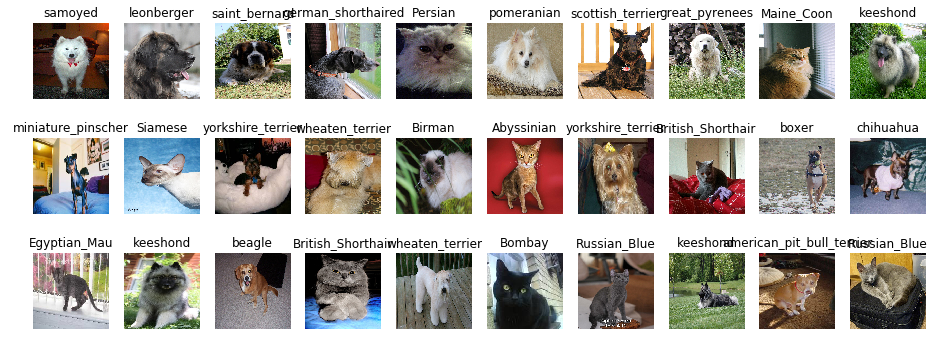

In [22]:
# testデータ30件の正解ラベル
true_classes = np.argmax(y_test[0:30], axis = 1)

# testデータ30件の画像と正解ラベルを出力
plt.figure(figsize = (16, 6))
for i in range(30):
    plt.subplot(3, 10, i +1)
    plt.axis("off")
    plt.title(kind_list[true_classes[i]])
    plt.imshow(Image.fromarray(np.uint8(X_test[i])))
plt.show()


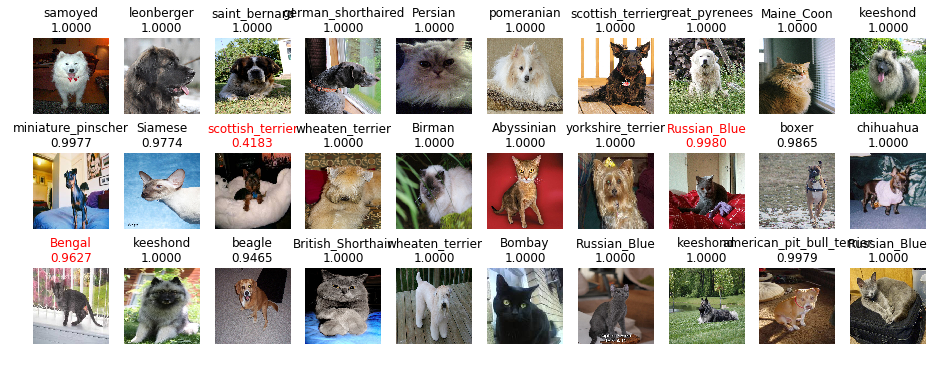

In [23]:
# testデータ30件の予測ラベル
pred_classes=np.argmax(model.predict(X_test[0:30]),axis=1)

# テストデータ30件の予測確率
pred_probs = np.max(model.predict(X_test[0:30]),axis=1)
pred_probs = ['{:.4f}'.format(i) for i in pred_probs]

# testデータ30件の画像と予測ラベル＆予測確率を出力
plt.figure(figsize = (16, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.axis("off")
    if pred_classes[i] == true_classes[i]:
        plt.title(kind_list[pred_classes[i]] + '\n' + pred_probs[i])
    else:
        plt.title(kind_list[pred_classes[i]] + '\n' + pred_probs[i], color = "red")
    plt.imshow(Image.fromarray(np.uint8(X_test[i])))
plt.show()

In [48]:
#保存したモデルの読み込み
model = load_model(model_dir + 'model_3-opt.hdf5', compile = False)
#保存した重みの読み込み
model.load_weights(model_dir + 'model_3_weight.hdf5')

kind_list = ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian'
            ,'Ragdoll','Russian_Blue','Siamese','Sphynx',
        'american_bulldog','american_pit_bull_terrier','basset_hound','beagle','boxer',
        'chihuahua', 'english_cocker_spaniel','english_setter', 'german_shorthaired','great_pyrenees',
        'havanese','japanese_chin','keeshond','leonberger','miniature_pinscher','newfoundland','pomeranian',
        'pug', 'saint_bernard','samoyed','scottish_terrier','shiba_inu','staffordshire_bull_terrier',
        'wheaten_terrier','yorkshire_terrier']

/content/images.jpeg


In [67]:
#画像を読み込む
img_path = str(input())
img = load_img(img_path,target_size=(224, 224))
x = img_to_array(img)
y = np.expand_dims(x, axis=0)

#予測
features = model.predict(y)



/content/S__2130075.jpg


Egyptian_Mau
0.7292


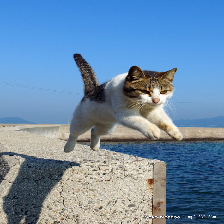

In [68]:
pred_classes=np.argmax(features, axis=1)

pred_probs = np.max(features,axis=1)
pred_probs = ['{:.4f}'.format(i) for i in pred_probs]

print(kind_list[pred_classes[0]] + '\n' + pred_probs[0])
Image.fromarray(np.uint8(x))